# Predicting House Prices with PySpark

Linear Regression

### 1. Importar las librerias necesarias

In [1]:
import pandas as pd
import numpy as np


import findspark
findspark.init()

import pyspark
import pyarrow

#Spark Session
from pyspark.sql import SparkSession


In [2]:
#Spark Context
from pyspark import SparkContext

#Spark fuctions
import pyspark.sql.functions as pyf

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DataType


from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.stat import Correlation

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
# Visualization

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sn

### 2. Crear la sesion de spark

In [4]:
spark = SparkSession.builder.appName("ML_spark").getOrCreate()
spark

### 3. Obtener los datos del fichero

In [79]:
#Obterner los datos del fichero csv definiendo un schenma

schema = StructType() \
    .add("longitude", FloatType(), True) \
    .add("latitude", FloatType(), True) \
    .add("housing_median_age", FloatType(), True) \
    .add("total_rooms", FloatType(), True) \
    .add("total_bedrooms", FloatType(), True) \
    .add("population", FloatType(), True) \
    .add("households", FloatType(), True) \
    .add("median_income", FloatType(), True) \
    .add("median_house_value", FloatType(), True) \
    .add("ocean_proximity", StringType(), True)

    
house_df = spark.read.format('csv') \
    .option('header',True) \
    .option('delimiter', ',') \
    .schema(schema) \
    .load('housing.csv')

house_df.printSchema()
house_df.show(5)



root
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- housing_median_age: float (nullable = true)
 |-- total_rooms: float (nullable = true)
 |-- total_bedrooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- households: float (nullable = true)
 |-- median_income: float (nullable = true)
 |-- median_house_value: float (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -1

In [80]:
#Numero de filas y columnas
print(house_df.count(), len(house_df.columns))

20640 10


.- Median house value (MHV) es la variable dependiente y se le asigna el rol de target en el modelo de ML.

.- Cada línea, corresponde a un "census block group" que corresponde a la unidad geográfica mas pequeña para la que publica datos la US Census Bureau (un típico block group tiene una población entre 600 y 3.000 personas).

.- Este dataset contiene 20.640 entradas con 10 columnas.

.- Tenemos datos numéricos y categóricos.

### 4. Exploratorio de datos (EDA)

In [81]:
#Ver un resumen de los datos numericos
house_df.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569115,2.003539,-124.349998,-121.800003,-118.489998,-118.010002,-114.309998
latitude,20640.0,35.631866,2.135956,32.540001,33.930000,34.259998,37.709999,41.950001
housing_median_age,20640.0,28.639486,12.585629,1.000000,18.000000,29.000000,37.000000,52.000000
total_rooms,20640.0,2635.758789,2181.604736,2.000000,1447.750000,2127.000000,3148.000000,39320.000000
total_bedrooms,20433.0,537.870544,421.384338,1.000000,296.000000,435.000000,647.000000,6445.000000
population,20640.0,1425.477905,1132.460815,3.000000,787.000000,1166.000000,1725.000000,35682.000000
households,20640.0,499.539673,382.329773,1.000000,280.000000,409.000000,605.000000,6082.000000
median_income,20640.0,3.870662,1.899820,0.499900,2.563400,3.534800,4.743250,15.000100
median_house_value,20640.0,206854.968750,115395.187500,14999.000000,119600.000000,179700.000000,264725.000000,500001.000000


In [66]:
#Compropbar si hay valores nulos
house_df.select([pyf.count(pyf.when(pyf.isnull(c) | pyf.isnan(c) , c)).alias(c) for c in house_df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



.- Aqui vemos que hay algunos missing values en: total_bedrooms.

.- Observamos que el mínimo y el máximo de los atributos numéricos y tienen un rango muy amplio. Se necesitará normalizar los datos.

In [82]:
#Reemplazar valores nulos por 0
house_df = house_df.na.fill(0)

In [83]:
house_df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float32
 1   latitude            20640 non-null  float32
 2   housing_median_age  20640 non-null  float32
 3   total_rooms         20640 non-null  float32
 4   total_bedrooms      20640 non-null  float32
 5   population          20640 non-null  float32
 6   households          20640 non-null  float32
 7   median_income       20640 non-null  float32
 8   median_house_value  20640 non-null  float32
 9   ocean_proximity     20640 non-null  object 
dtypes: float32(9), object(1)
memory usage: 887.0+ KB


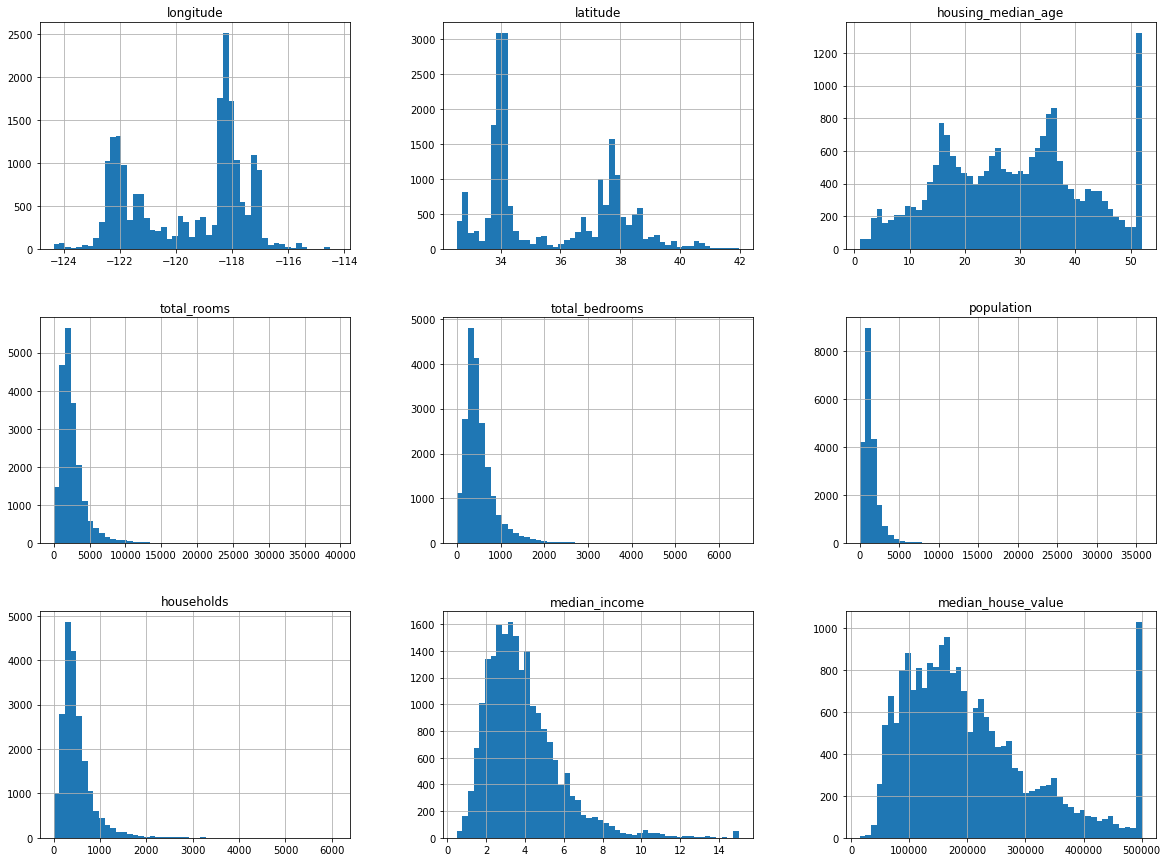

In [84]:
#Comporbar la distribución de los datos con un histograma (se convierte a un dataframe de pandas)

house_pd = house_df.toPandas()
house_pd.hist(bins=50, figsize=(20,15))
plt.show()

In [85]:
#Agrupar por median_age y ver la distribución
house_df.select(pyf.max('housing_median_age'), pyf.min('housing_median_age'),\
    pyf.mean('housing_median_age'), pyf.stddev('housing_median_age')).show()

+-----------------------+-----------------------+-----------------------+-------------------------------+
|max(housing_median_age)|min(housing_median_age)|avg(housing_median_age)|stddev_samp(housing_median_age)|
+-----------------------+-----------------------+-----------------------+-------------------------------+
|                   52.0|                    1.0|     28.639486434108527|              12.58555761211163|
+-----------------------+-----------------------+-----------------------+-------------------------------+



In [86]:
#Agrupar por la variable categórica y ver que grupos contiene
house_df.groupBy('ocean_proximity').count().orderBy('count').show()

+---------------+-----+
|ocean_proximity|count|
+---------------+-----+
|         ISLAND|    5|
|       NEAR BAY| 2290|
|     NEAR OCEAN| 2658|
|         INLAND| 6551|
|      <1H OCEAN| 9136|
+---------------+-----+



.-El coeficiente de correlación toma valores entre -1 y 1. Cuando está mas cercano a 1, significa que hay una correalción muy positiva.

.-En este caso, la median_house_value aumenta cuando es mas alto la median_income.

### 5. Data Preprocesing

Con la información que ya hemos obtenido sabemos ya que no tenemos valores nulos, probablemente habrá que estandarizar los datos, podemos añadir nuevos atributos (numero de dormitorios por habitación), la variable dependiente también es grande asi que habrá quea ajustarla también.

In [87]:
#Ajustar los valores de 'median_house_value' a unidades de 100.000
#col() para seleccionar la columna que se quiere utilizar

house_df = house_df.withColumn('median_house_value', pyf.col('median_house_value') / 100000)

house_df.show(2)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|             4.526|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|             3.585|       NEAR BAY|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 2 rows



Transformar los valores categóricos a numéricos

String Indexing = Label Encoding


In [88]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [89]:
house_df_SI = StringIndexer(inputCol='ocean_proximity', outputCol='ocean_index')

In [90]:
#Transformar los datos
house_df = house_df_SI.fit(house_df).transform(house_df)

In [94]:
#Correlación entre las variables independientes y la variable target
import six
for i in house_df.columns:
    if not(isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print("Correlation to MHV for ", i, house_df.stat.corr('median_house_value',i))

Correlation to MHV for  longitude -0.045966628709323575
Correlation to MHV for  latitude -0.1441602712651097
Correlation to MHV for  housing_median_age 0.10562341249321133
Correlation to MHV for  total_rooms 0.13415311380656342
Correlation to MHV for  total_bedrooms 0.04914821959942523
Correlation to MHV for  population -0.024649678888894855
Correlation to MHV for  households 0.06584265057005657
Correlation to MHV for  median_income 0.6880752074646901
Correlation to MHV for  median_house_value 1.0
Correlation to MHV for  ocean_index 0.02173220425145644


### 6. Feature Engineering

Una vez ajustados los valores del valor medio, vamos a añadir unas columnas nuevas que aportaran valor al análisis:

.- rooms_household: el numero de habitaciones de un hosehold por block group

.- pop_household: cuánta gente vive en cada household por block group

.- bedrooms_room: cuántos dormitorios hay por cada habitación por block group

In [95]:
#Añadimos las nuevas columnas

house_df = house_df.withColumn('rooms_household', pyf.round(pyf.col('total_rooms') / pyf.col('households'), 2)) \
                    .withColumn('pop_household', pyf.round(pyf.col('population') / pyf.col('households'), 2)) \
                    .withColumn('bedrooms_room', pyf.round(pyf.col('total_bedrooms') / pyf.col('total_rooms'), 2))
            
house_df.show(5)
house_df.printSchema()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------+---------------+-------------+-------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|ocean_index|rooms_household|pop_household|bedrooms_room|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------+---------------+-------------+-------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|             4.526|       NEAR BAY|        3.0|           6.98|         2.56|         0.15|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|             3.585|       NEAR BAY|        3.0|           6.24|         2.11|         0.16|
|  -122.24|   37.85|          

In [96]:
house_df.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'ocean_index',
 'rooms_household',
 'pop_household',
 'bedrooms_room']

En este punto del análisis, vamos a descartar aquellas variables que no vamos a necesitar: 'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'ocean_proximity'.

In [99]:
#Usamos select() con el nombre de las columnas que vamos a utilizar y ponemos la variable target en primera posición.

house_df2 = house_df.select('median_house_value', 'total_bedrooms', \
                           'population', 'households','median_income', \
                           'rooms_household', 'pop_household','bedrooms_room', 'ocean_index')

house_df2.show(2)

+------------------+--------------+----------+----------+-------------+---------------+-------------+-------------+-----------+
|median_house_value|total_bedrooms|population|households|median_income|rooms_household|pop_household|bedrooms_room|ocean_index|
+------------------+--------------+----------+----------+-------------+---------------+-------------+-------------+-----------+
|             4.526|         129.0|     322.0|     126.0|       8.3252|           6.98|         2.56|         0.15|        3.0|
|             3.585|        1106.0|    2401.0|    1138.0|       8.3014|           6.24|         2.11|         0.16|        3.0|
+------------------+--------------+----------+----------+-------------+---------------+-------------+-------------+-----------+
only showing top 2 rows



Comprobamos que el nuevo df no hay valores nulos o vacios, si los hubiese, prodeceremos a eliminarlos.

In [102]:
columns =  ['total_bedrooms', 'population', 'households', 'median_income', \
            'rooms_household', 'pop_household', 'bedrooms_room']

house_df2.select([pyf.count(pyf.when(pyf.isnan(c) | pyf.isnull(c) , c)).alias(c) for c in house_df2.columns]).show()


+------------------+--------------+----------+----------+-------------+---------------+-------------+-------------+-----------+
|median_house_value|total_bedrooms|population|households|median_income|rooms_household|pop_household|bedrooms_room|ocean_index|
+------------------+--------------+----------+----------+-------------+---------------+-------------+-------------+-----------+
|                 0|             0|         0|         0|            0|              0|            0|            0|          0|
+------------------+--------------+----------+----------+-------------+---------------+-------------+-------------+-----------+



6.1. Normalizar los datos.

In [103]:
#Selección de las columnas
featureCols = ['total_bedrooms', 'population', 'households', \
               'median_income', 'rooms_household', 'pop_household', 'bedrooms_room', 'ocean_index']

In [104]:
#Utilizamos VectorAssembler para crear una nueva columna (features) que contenga un vector simple con todas las características.
assembler = VectorAssembler(inputCols=featureCols, outputCol='features')

In [105]:
assembled_df = assembler.transform(house_df2)

In [106]:
assembled_df.select('features').show(2, False)

+-----------------------------------------------------------+
|features                                                   |
+-----------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15,3.0]   |
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16,3.0]|
+-----------------------------------------------------------+
only showing top 2 rows



6.2. Estandarización

Los input son las "features", los output las "features_scaled".

In [107]:
#Utilizamos standarScaler
standardScaler = StandardScaler(inputCol='features', outputCol='features_scaled')

In [108]:
#Ajustamos el dataframe
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [109]:
#Comprobamos el resultado
scaled_df.select('features', 'features_scaled').show(5)

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[129.0,322.0,126....|[0.30519662349887...|
|[1106.0,2401.0,11...|[2.61664702007560...|
|[190.0,496.0,177....|[0.44951440670376...|
|[235.0,558.0,219....|[0.55597834513360...|
|[280.0,565.0,259....|[0.66244228356344...|
+--------------------+--------------------+
only showing top 5 rows



## 7. Machine Learning model con Spark ML

### Regresión lineal

In [110]:
#Fijamos el random seed
rnd_seed = 42 
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [111]:
#Dividimos en dataset en train y test
train_data, test_data = scaled_df.randomSplit([.8, .2], seed=rnd_seed)

In [112]:
#Inicializar el modelo
lr = LinearRegression(featuresCol='features', labelCol='median_house_value', predictionCol='pred_medianHouseValue', \
                      maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False)

In [113]:
#Ajustar los datos al modelo
linearModel = lr.fit(train_data)

### 8. Evaluar el modelo

Una vez que ya tenemos el modelo podemos generar predicciones para el test_data

8.1 Model CO-efficients

Coefficients are the values that multiply the predictor values.

In [114]:
print('Coefficients: ' + str(linearModel.coefficients))


Coefficients: [0.0002528521953971656,-0.0004325212732261637,0.0010726909249619834,0.3501216572999762,0.0,0.0,0.0,0.0]


In [115]:
featureCols

['total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_household',
 'pop_household',
 'bedrooms_room',
 'ocean_index']

In [116]:
print('Intercept: ' + str(linearModel.intercept))

Intercept: 0.6574451052892929


In [117]:
coef_df = pd.DataFrame({'Feature': ['Intercept'] + featureCols, 'Co-efficients': np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})

coef_df = coef_df[['Feature', 'Co-efficients']]

In [118]:
coef_df

,Feature,Co-efficients
0,Intercept,0.657445
1,total_bedrooms,0.000253
2,population,-0.000433
3,households,0.001073
4,median_income,0.350122
5,rooms_household,0.000000
6,pop_household,0.000000
7,bedrooms_room,0.000000
8,ocean_index,0.000000


Predicciones

In [119]:
predictions = linearModel.transform(test_data)
pred_labels = predictions.select('pred_medianHouseValue', 'median_house_value')
pred_labels.show(5)

+---------------------+------------------+
|pred_medianHouseValue|median_house_value|
+---------------------+------------------+
|   1.4171181147419074|           0.14999|
|   0.9392333131409076|             0.225|
|   0.6356459576722737|             0.225|
|  0.05983758943192896|             0.283|
|   1.3659970125048981|             0.325|
+---------------------+------------------+
only showing top 5 rows



Métricas

In [120]:
#Root Mean Square Error, R2

trainingSummary = linearModel.summary
print("RMSE: {0}".format(trainingSummary.rootMeanSquaredError))
print("r2: {0}".format(trainingSummary.r2))

RMSE: 0.817788886772443
r2: 0.49645640419837456


.- RMSE: measures the differences between predicted values by the model and the actual values. The smaller RMSE value is, the closer predicted and observed values are.

.- R-squared: measure that shows how close the data are to the fitted regression line. This score will always be between 0 and a 100% (or 0 to 1 in this case). In general, the higher the R-squared, the better the model fits our data.

In [121]:
#Vemos algunas métricas
train_data.describe('median_house_value').show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             16560|
|   mean|2.0610837336956918|
| stddev|1.1524863204525246|
|    min|           0.14999|
|    max|           5.00001|
+-------+------------------+



Usamos "Regression evaluator" de pyspark.ml para evaluar el modelo

In [122]:
evaluator = RegressionEvaluator(predictionCol='pred_medianHouseValue', labelCol='median_house_value', metricName='rmse')
print("RMSE = %g" % evaluator.evaluate(pred_labels))

RMSE = 0.813606


In [123]:
evaluator = RegressionEvaluator(predictionCol='pred_medianHouseValue', labelCol='median_house_value', metricName='r2')
print("R Squared (R2)  = %g" % evaluator.evaluate(pred_labels))

R Squared (R2)  = 0.507557


#### En este caso, parece que nuestro modelo no ajusta lo sufieciente. De todas formas, debemos comprar el RMSE con el actual "median_house_value", la media y el min y max.

In [124]:
spark.stop()